# Transfer learning with pretrained Keras models

Although Kernel resources were increased recently we still can not train useful CNNs without GPU. The original ImageNet set has quite a few different dog classes so we can reuse CNNs with pretrained ImageNet weights. Fortunately prediction is much faster (<1s/image) making it possible to run meaningful experiments with Kaggle Kernels.

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import h5py
from PIL import Image
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression

/Users/tqrahman/.local/share/virtualenvs/dog-breeds-classifier-uKqqz_WY/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
start = dt.datetime.now()

# Use Keras Pretrained Models dataset

Kernels can't use network connection to download pretrained keras model weights.
This dataset helps you to apply your favorite pretrained model in the Kaggle Kernel environment. 
You can find more details [here](https://www.kaggle.com/gaborfodor/keras-pretrained-models).

We have to copy the pretrained models to the cache directory (~/.keras/models) where keras is looking for them.


In [ ]:
#!ls ../input/keras-pretrained-models/

In [ ]:
'''
cache_dir = expanduser(join('~', '.keras'))
if not exists(cache_dir):
    makedirs(cache_dir)
models_dir = join(cache_dir, 'models')
if not exists(models_dir):
    makedirs(models_dir)
'''
!pip3 install --upgrade h5py

In [ ]:
'''
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/
!cp ../input/keras-pretrained-models/resnet50* ~/.keras/models/
'''

In [ ]:
'''
!ls ~/.keras/models
'''

In [32]:
'''
!ls ../input/dog-breed-identification
'''

'\n!ls ../input/dog-breed-identification\n'

# Use top 16 classes
Using all the images would take more than the 1 hour kernel limit. Let's focus on the most frequent 16 breeds.

In [7]:
INPUT_SIZE = 224
NUM_CLASSES = 120
SEED = 1987
data_dir = './input/dog-breed-identification'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222
10357 10357


In [8]:
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [9]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
y_train = labels_pivot[selected_breed_list].values
ytr = y_train[train_idx]
yv = y_train[valid_idx]

In [17]:
labels.head()

,id,breed,target,rank
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,1,1.0
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,1,1.0
2,001cdf01b096e06d78e9e5112d419397,pekinese,1,1.0
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,1,1.0
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,1,1.0


In [18]:
labels[labels['breed']=='boston_bull']

,id,breed,target,rank
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,1,1.0
38,010d65bd29d246aea53d9849da142ccf,boston_bull,1,2.0
304,0755a940eac9a9b8cf0328b4be062096,boston_bull,1,3.0
324,07d7cfbdbd3682cae50902b53c798028,boston_bull,1,4.0
471,0b3d3120a62c2bc280f589d473041d06,boston_bull,1,5.0
675,10730dfd280bb4b2723dc677378f2ff1,boston_bull,1,6.0
712,118060ca946af5cfd1b3bbe030f9003c,boston_bull,1,7.0
808,13f939b9b15ec56409a21017263db93c,boston_bull,1,8.0
832,146be641443a270dd8116f65d53d0c9d,boston_bull,1,9.0
924,16aaa590e39530bc1cb319fc7d89c00e,boston_bull,1,10.0


In [10]:
def read_img(img_id, train_or_test, size):
    """Read and resize image.
    # Arguments
        img_id: string
        train_or_test: string 'train' or 'test'.
        size: resize the original image.
    # Returns
        Image as numpy array.
    """
    img = image.load_img(join(data_dir, train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

# ResNet50 class predictions for example images

In [15]:
model = ResNet50(weights='imagenet')

In [16]:
duh = labels.loc[labels['rank'] == 1, ['id', 'breed']].values

In [22]:
duh[0]

array(['000bec180eb18c7604dcecc8fe0dba07', 'boston_bull'], dtype=object)

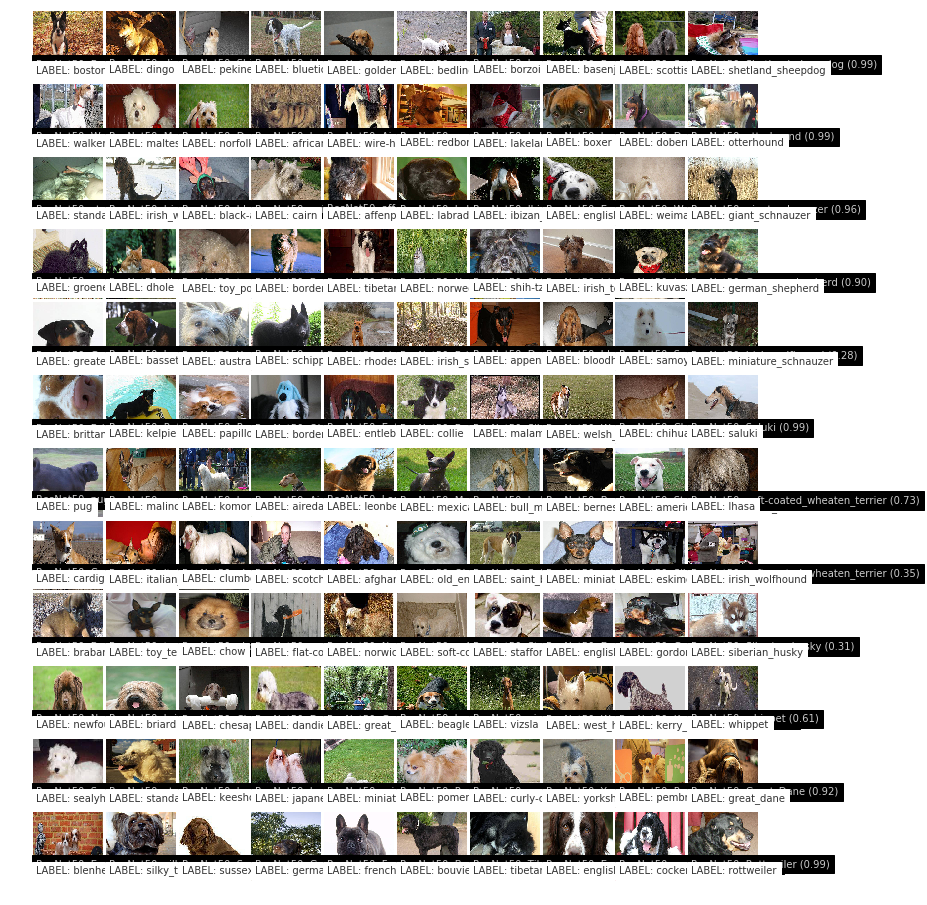

In [11]:
j = int(np.sqrt(NUM_CLASSES))
i = int(np.ceil(1. * NUM_CLASSES / j))
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(i, j), axes_pad=0.05)

for i, (img_id, breed) in enumerate(duh):
    ax = grid[i]
    img = read_img(img_id, 'train', (224, 224))
    ax.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    preds = model.predict(x)
    _, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0]
    ax.text(10, 180, 'ResNet50: %s (%.2f)' % (imagenet_class_name , prob), color='w', backgroundcolor='k', alpha=0.8)
    ax.text(10, 200, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
plt.show()

In [20]:
test = listdir(join(data_dir, 'test'))

In [26]:
img_path = test[0]
img_path

'266490a2b053a4a3bf68e779f28fb5a9.jpg'

In [ ]:
img = read_img(img_id, 'test', (224, 224))
x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    preds = model.predict(x)
    _, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0]

In [28]:
img_path = test[0]
img = image.load_img("./input/dog-breed-identification/test/"+img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)
preds = model.predict(x)

In [35]:
preds.shape

(1, 1000)

In [21]:
model.predict()

AttributeError: 'str' object has no attribute 'ndim'

Preprocessing and prediction seems to be working. 75% accuracy on these 16 images.

# Extract VGG16 bottleneck features

In [12]:
INPUT_SIZE = 224
POOLING = 'avg'
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

1777it [00:09, 182.36it/s]

Train Images shape: (1777, 224, 224, 3) size: 267,488,256


In [13]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
vgg_bottleneck = VGG16(weights='imagenet', include_top=False, pooling=POOLING)
train_vgg_bf = vgg_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_vgg_bf = vgg_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('VGG train bottleneck features shape: {} size: {:,}'.format(train_vgg_bf.shape, train_vgg_bf.size))
print('VGG valid bottleneck features shape: {} size: {:,}'.format(valid_vgg_bf.shape, valid_vgg_bf.size))

((1409, 224, 224, 3), (368, 224, 224, 3), (1409, 16), (368, 16))
368/368 [==============================] - 288s 784ms/step
VGG train bottleneck features shape: (1409, 512) size: 721,408
VGG valid bottleneck features shape: (368, 512) size: 188,416


# LogReg on VGG bottleneck features

In [14]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_vgg_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_vgg_bf)
valid_preds = logreg.predict(valid_vgg_bf)

In [15]:
print('Validation VGG LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation VGG Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Validation VGG LogLoss 0.35205974794606615
Validation VGG Accuracy 0.9184782608695652


Not bad, 90% accuracy for the top 16 classes. The multiclass classification with 120 classes is more difficult so these LogLoss/Accuracy scores does not translate to LB.

# Extract Xception bottleneck features

In [16]:
INPUT_SIZE = 299
POOLING = 'avg'
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = xception.preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

1777it [00:09, 183.91it/s]

Train Images shape: (1777, 299, 299, 3) size: 476,596,731


In [17]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
xception_bottleneck = xception.Xception(weights='imagenet', include_top=False, pooling=POOLING)
train_x_bf = xception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_x_bf = xception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('Xception train bottleneck features shape: {} size: {:,}'.format(train_x_bf.shape, train_x_bf.size))
print('Xception valid bottleneck features shape: {} size: {:,}'.format(valid_x_bf.shape, valid_x_bf.size))

((1409, 299, 299, 3), (368, 299, 299, 3), (1409, 16), (368, 16))
368/368 [==============================] - 268s 729ms/step
Xception train bottleneck features shape: (1409, 2048) size: 2,885,632
Xception valid bottleneck features shape: (368, 2048) size: 753,664


# LogReg on Xception bottleneck features


In [18]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_x_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_x_bf)
valid_preds = logreg.predict(valid_x_bf)
print('Validation Xception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Xception Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Validation Xception LogLoss 0.06829598590262777
Validation Xception Accuracy 0.9809782608695652


![](https://pics.me.me/such-wow-much-awesome-many-cool-bestest-thug-life-19337110.png)

Much better! 98% accuracy 0.07 LogLoss.

# Extract Inception bottleneck features

In [19]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))
inception_bottleneck = inception_v3.InceptionV3(weights='imagenet', include_top=False, pooling=POOLING)
train_i_bf = inception_bottleneck.predict(Xtr, batch_size=32, verbose=1)
valid_i_bf = inception_bottleneck.predict(Xv, batch_size=32, verbose=1)
print('InceptionV3 train bottleneck features shape: {} size: {:,}'.format(train_i_bf.shape, train_i_bf.size))
print('InceptionV3 valid bottleneck features shape: {} size: {:,}'.format(valid_i_bf.shape, valid_i_bf.size))

((1409, 299, 299, 3), (368, 299, 299, 3), (1409, 16), (368, 16))
368/368 [==============================] - 151s 411ms/step
InceptionV3 train bottleneck features shape: (1409, 2048) size: 2,885,632
InceptionV3 valid bottleneck features shape: (368, 2048) size: 753,664


# LogReg on Inception bottleneck features

In [20]:
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(train_i_bf, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(valid_i_bf)
valid_preds = logreg.predict(valid_i_bf)

In [21]:
print('Validation Inception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Inception Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Validation Inception LogLoss 0.08069913954479578
Validation Inception Accuracy 0.967391304347826


# LogReg on all bottleneck features

In [22]:
X = np.hstack([train_x_bf, train_i_bf])
V = np.hstack([valid_x_bf, valid_i_bf])
print('Full train bottleneck features shape: {} size: {:,}'.format(X.shape, X.size))
print('Full valid bottleneck features shape: {} size: {:,}'.format(V.shape, V.size))
logreg = LogisticRegression(multi_class='multinomial', solver='lbfgs', random_state=SEED)
logreg.fit(X, (ytr * range(NUM_CLASSES)).sum(axis=1))
valid_probs = logreg.predict_proba(V)
valid_preds = logreg.predict(V)
print('Validation Xception + Inception LogLoss {}'.format(log_loss(yv, valid_probs)))
print('Validation Xception + Inception Accuracy {}'.format(accuracy_score((yv * range(NUM_CLASSES)).sum(axis=1), valid_preds)))

Full train bottleneck features shape: (1409, 4096) size: 5,771,264
Full valid bottleneck features shape: (368, 4096) size: 1,507,328
Validation Xception + Inception LogLoss 0.07085797531382107
Validation Xception + Inception Accuracy 0.9755434782608695


Training this model on the full dataset would give 0.3 LogLoss on LB.

# Check errors
We still have a few misclassification errors.

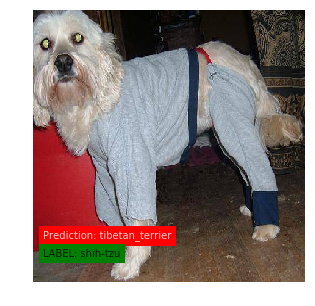

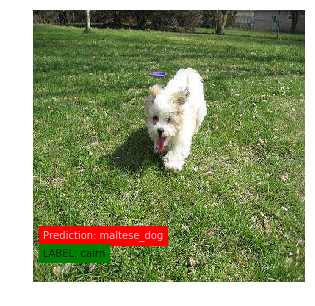

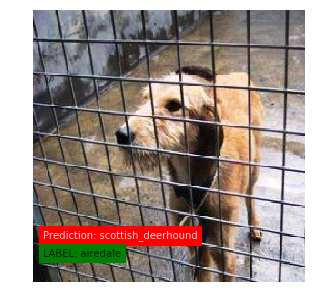

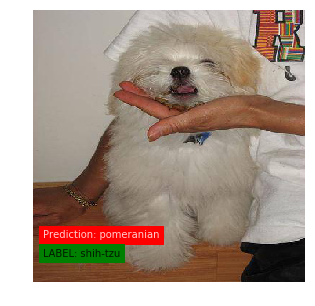

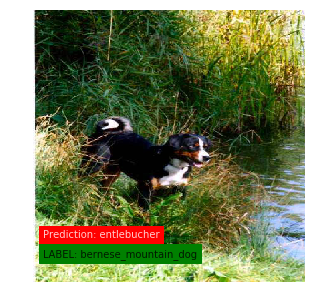

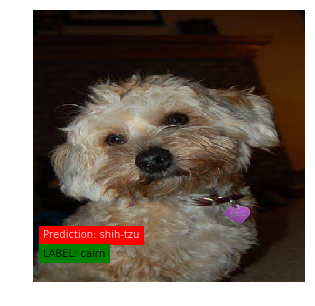

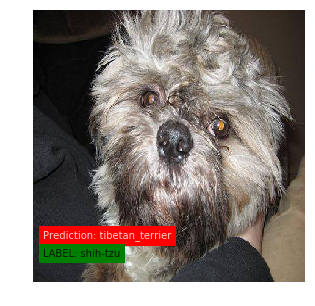

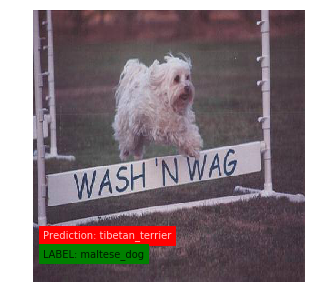

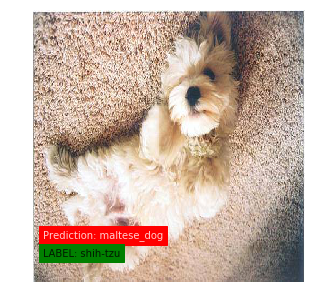

In [23]:
valid_breeds = (yv * range(NUM_CLASSES)).sum(axis=1)
error_idx = (valid_breeds != valid_preds)
for img_id, breed, pred in zip(labels.loc[valid_idx, 'id'].values[error_idx],
                                [selected_breed_list[int(b)] for b in valid_preds[error_idx]],
                                [selected_breed_list[int(b)] for b in valid_breeds[error_idx]]):
    fig, ax = plt.subplots(figsize=(5,5))
    img = read_img(img_id, 'train', (299, 299))
    ax.imshow(img / 255.)
    ax.text(10, 250, 'Prediction: %s' % pred, color='w', backgroundcolor='r', alpha=0.8)
    ax.text(10, 270, 'LABEL: %s' % breed, color='k', backgroundcolor='g', alpha=0.8)
    ax.axis('off')
    plt.show()                                                    

In [24]:
end = dt.datetime.now()
print('Total time {} s.'.format((end - start).seconds))
print('We almost used the one hour time limit.')

Total time 3401 s.
We almost used the one hour time limit.
